### Motivación

Con las homografías que hemos estudiado hasta ahora solo podemos añadir objetos virtuales dentro del plano de referencia.

<img src="../images/demos/rap.png" width="40%"/>

Hoy aprenderemos a añadir objetos tridimensionales, escapando del plano del marcador.

<img src="../images/demos/ra.png" width="40%"/>

Además, podemos obtener la posición de la cámara en el espacio.

<img src="../images/demos/axes.png" width="50%"/>

# Modelo de cámara

En el tema anterior hemos visto que las transformaciones que sufren las escenas planas cuando se proyectan en una imagen son lineales (si usamos coordenadas homogéneas) y por tanto se expresan mediante una matriz H de 3x3 elementos que llamamos "homografía". Si conocemos esta matriz podemos dehacer la deformación de perspectiva y rectificar el plano. La matriz H se puede deducir de la transformación sufrida por 4 o más puntos. Las homografías sirven también para transferir cuadriláteros o hacer mosaicos panorámicos.

Pero el mundo real es 3D. Las imágenes son el resultado de proyectar los puntos del espacio en el plano de imagen.
<img src="../images/demos/pinhole.svg" width="30%"/>

Esto significa que una escena tridimensional no se puede "rectificar" o "reconstruir" con una única imagen: cada pixel puede venir de todos los puntos 3D que están en el mismo rayo óptico. Se pierde la "profundidad" de los puntos. Para reconstruir la escena necesitamos varias imágenes.  La forma de hacer esto se explica en el capítulo siguiente pero antes es necesario estudiar la geometría elemental de una sola vista.

---

Los conceptos esenciales que aprenderemos son:

- La transformación que sufre la escena 3D cuando se observa en una imagen se representa mediante una matriz 3x4 que llamamos "**matriz de cámara**".


- La matriz de cámara tiene dos componentes: uno es la **matriz de calibración** $\mathsf K$ (que obtuvimos en el ejercicio FOV) y el otro es la **pose** (posición y orientación) de la cámara en el espacio.


- La matriz de cámara se puede deducir de las posiciones observadas en la imagen de un conjunto de puntos de referencia (p. ej. un marcador). Para ello utilizamos `cv.solvePnP`.



Si recuperamos la matriz de cámara podremos añadir objetos virtuales 3D a la escena y deducir dónde está situada la cámara en el espacio.


---


Las tarjetas gráficas son dispositivos hardware capaces de multiplicar a una velocidad impresionante estas matrices por las coordenadas de los objetos que aparecen en el videojuego para conseguir imágenes realistas. La visión artificial trata de realizar el proceso inverso: partiendo de las imágenes deseamos obtener un modelo 3D de la escena.

## Herramientas

Las siguientes utilidades se han usado anteriormente.

In [ ]:
import numpy as np
import cv2   as cv

import matplotlib.pyplot as plt
import numpy.linalg      as la

from ipywidgets          import interactive

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    plt.imshow(x, "gray")

# para imprimir arrays con el número de decimales deseados
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

def sharr(a, prec=3):
    with printoptions(precision=prec, suppress=True):
        print(a)
    
# muestra un polígono cuyos nodos son las filas de un array 2D
def shcont(c, color='blue', nodes=True):
    x = c[:,0]
    y = c[:,1]
    x = np.append(x,x[0])
    y = np.append(y,y[0])
    plt.plot(x,y,color)
    if nodes: plt.plot(x,y,'.',color=color, markersize=11)

# crea un vector (array 1D), conveniente para hacer operaciones matemáticas
def vec(*argn):
    return np.array(argn)

# convierte un conjunto de puntos ordinarios (almacenados como filas de la matriz de entrada)
# en coordenas homogéneas (añadimos una columna de 1)
def homog(x):
    ax = np.array(x)
    uc = np.ones(ax.shape[:-1]+(1,))
    return np.append(ax,uc,axis=-1)

# convierte en coordenadas tradicionales
def inhomog(x):
    ax = np.array(x)
    return ax[..., :-1] / ax[...,[-1]]

# aplica una transformación homogénea h a un conjunto
# de puntos ordinarios, almacenados como filas 
def htrans(h,x):
    return inhomog(homog(x) @ h.T)

pi = np.pi
degree = pi/180

En esta clase añadimos las siguientes utilidades:

In [2]:
# para dibujar en 3D
from mpl_toolkits.mplot3d import Axes3D

# crea una matriz columna a partir de elementos o de un vector 1D
def col(*args):
    a = args[0]
    n = len(args)
    if n==1 and type(a) == np.ndarray and len(a.shape) == 1:
        return a.reshape(len(a),1)
    return np.array(args).reshape(n,1)

# crea una matriz fila
def row(*args):
    return col(*args).T

# juntar columnas
def jc(*args):
    return np.hstack(args)

# juntar filas
def jr(*args):
    return np.vstack(args)

# dibujar una polilínea en 3D
def plot3(ax,c,color):
    x,y,z = c.T
    ax.plot(x,y,z,color)

## Transformaciones del espacio

Los **desplazamientos** y los cambios de **escala** que hemos visto en 2D tienen su análogo directo en el espacio 3D. En las **rotaciones**, además del ángulo, aparece el eje de giro. Hay varias formas de representarlas.

Definimos un objeto 3D de prueba para observar el efecto de las transformaciones.

In [3]:
cube = np.array([
    [0,0,0],
    [1,0,0],
    [1,1,0],
    [0,1,0],
    [0,0,0],
    
    [0,0,1],
    [1,0,1],
    [1,1,1],
    [0,1,1],
    [0,0,1],
        
    [1,0,1],
    [1,0,0],
    [1,1,0],
    [1,1,1],
    [0,1,1],
    [0,1,0]
    ])

def ejes(ax,d):
    plot3(ax,np.array([[0,0,0],[d,0,0]]),'gray')
    plot3(ax,np.array([[0,0,0],[0,d,0]]),'gray')
    plot3(ax,np.array([[0,0,0],[0,0,d]]),'gray')

Con matplotlib podemos visualizar el objeto desde diferentes puntos de vista:

In [4]:
def fun(a=-30):
    fig = plt.figure(figsize=(6,6)) # empezamos figura 3D
    ax = fig.add_subplot(111, projection='3d')
    plot3(ax,cube,'g');
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ejes(ax,3)
    ax.view_init(elev=30., azim=a)

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=-30, description='a', max=180, min=-180, step=10), Output()), _dom_class…

Redefinimos las transformaciones para que funcionen en cualquier dimensión:

In [5]:
# desplazamiento
def desp(d):
    n = len(d)
    D = np.eye(n+1)
    D[:n,-1] = d
    return D

# escalado
def scale(s):
    return np.diag(np.append(s,1))

Una matriz de desplazamiento en el plano tiene 3x3 elementos:

In [6]:
desp([1,2])

array([[1., 0., 1.],
       [0., 1., 2.],
       [0., 0., 1.]])

Y un desplazamiento en el espacio tiene 4x4 elementos. Las coordenadas homogéneas del espacio son vectores de dimensión 4.

In [7]:
desp([1,2,3])

array([[1., 0., 0., 1.],
       [0., 1., 0., 2.],
       [0., 0., 1., 3.],
       [0., 0., 0., 1.]])

Un escalado 3D:

In [8]:
scale((1,2,3))

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 1]])

Las rotaciones en el espacio son más delicadas. Una forma intuitiva de expresarlas es mediante un vector (eje de giro) y ángulo ([fórmula de Rodrigues](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula)):

In [9]:
def unit(v):
    return v / la.norm(v)

def rotation(v, a=None, homog=False):
    if a==None:
        R = cv.Rodrigues(v)[0]
    else:
        R = cv.Rodrigues(unit(v)*a)[0]
    if homog:
        Rh = np.eye(4)
        Rh[:3,:3] = R
        return Rh
    else:
        return R

In [10]:
rotation((1,0,0), 45*degree)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678],
       [ 0.        ,  0.70710678,  0.70710678]])

Si se omite el argumento de ángulo se sobreentiende que va codificado como la norma del vector:

In [11]:
rotation((0,30*degree,0))

array([[ 0.8660254,  0.       ,  0.5      ],
       [ 0.       ,  1.       ,  0.       ],
       [-0.5      ,  0.       ,  0.8660254]])

Opcionalmente se puede devolver como transformación homogénea:

In [12]:
rotation((1,1,1), 30*degree, homog=True)

array([[ 0.9106836 , -0.24401694,  0.33333333,  0.        ],
       [ 0.33333333,  0.9106836 , -0.24401694,  0.        ],
       [-0.24401694,  0.33333333,  0.9106836 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Podemos construir cualquier transformación del espacio componiendo transformaciones elementales. Por ejemplo:

In [13]:
H = desp((5,0,3)) @ scale((2,2,2)) @ rotation((1,1,1),30*degree,homog=True)

sharr(H)

[[ 1.821 -0.488  0.667  5.   ]
 [ 0.667  1.821 -0.488  0.   ]
 [-0.488  0.667  1.821  3.   ]
 [ 0.     0.     0.     1.   ]]


Veamos cómo queda el cubo cuando le aplicamos la transformarción anterior.

In [14]:
cube2 = htrans(H,cube)

def fun(a=-30):
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('auto')
    plot3(ax,cube,'g')
    plot3(ax,cube2,'red')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ejes(ax,3)
    ax.view_init(elev=30., azim=a)

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=-30, description='a', max=180, min=-180, step=10), Output()), _dom_class…

Es una transformación similar, el cubo preserva sus dimensiones relativas. (No hay ningún problema en aplicar transformaciones afines o proyectivas. En este último caso el cubo podría quedar como una especie de pirámide truncada.)

## Proyección

Veamos ahora cómo se puede implementar el efecto de perspectiva mediante una transformación lineal de coordenadas homogéneas.

La imagen $x$ de un punto del espacio $(X,Z)$ es la intersección del plano de imagen con el rayo que une el centro óptico con dicho punto.

<img src="../images/demos/ecbasic.png" width="500px"/>

**OJO**: por error los ejes están etiquetados al revés.


Por semejanza de triángulos $\frac{x}{f} = \frac{X}{Z}$. Entonces, en este sistema de referencia, denominado "sistema de referencia de la cámara", en el que el eje Z apunta hacia delante, transformación de coordenadas tiene la expresión simple, aunque no lineal:

$$ x = f\; \frac{X}{Z} \hspace{3em} y = f\; \frac{Y}{Z} $$

Es un cambio de escala que depende de la distancia. Los planos perpendiculares al plano de imagen no se deforman.


Esta operación de proyección se reduce a una sencilla transformación lineal de coordenadas homogéneas con la siguiente matriz de coeficientes (válida para el caso particular $f$=1, luego veremos como reintroducir este parámetro):

$$\mathsf P = \begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\end{bmatrix} $$

Al actuar sobre un punto del espacio produce un punto del plano cuya tercera coordenada homogénea es la profundidad $Z$. 

$$ \begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\end{bmatrix}\; \lambda \begin{bmatrix}X\\Y\\Z\\1\end{bmatrix} = \lambda \begin{bmatrix}X\\Y\\Z\end{bmatrix}$$

La división por $Z$ de la fórmula anterior no se realiza al transformar el punto sino al pasarlo después a coordenadas cartesianas. Esto solo es necesario para dibujar al final del proceso de cómputo. De hecho, las bibliotecas gráficas admiten directamente coordenadas homogéneas. Si no se necesitan las coordenadas cartesianas, podemos seguir operando con el vector homogéneo multiplicandolo por otras matrices.

En cierto sentido, las coordenadas homogéneas son una forma de representar un cociente $a/b$ guardando por separado el numerador y el denominador.

En situaciones normales la cámara no estará justo en el origen y apuntando en dirección del eje $Z$. Como veremos dentro de un momento, la matriz de proyección P se puede combinar con un desplazamiento y una rotación para conseguir el efecto de situar la cámara en cualquier posición y orientación.

## Matriz de calibración

Nos falta un último ingrediente para conseguir la matriz de cámara .

La matriz $\mathsf P$ proyecta los puntos 3D en el plano de imagen, que representamos en color verde en la figura siguiente.


<img src="../images/demos/pinhole1.png" width="30%"/>

Para su tratamiento informático tenemos que digitalizar la imagen con un sensor (un array de celdas sensibles a la luz), que produce una "matriz de pixels". La representamos en color rojo:


<img src="../images/demos/pinhole2.png" width="30%"/>

La siguiente figura muestra el plano de imagen de frente con sus dos sistemas de referencia: el de la imagen física $(x,y)$ (verde) y el de la imagen digitalizada (fila,columna) (rojo).

<img src="../images/demos/pinhole3.png" width="30%"/>

La transformación de uno a otro consiste en un cambio de escala (que tiene que ver con la resolución de la imagen) y un desplazamiento (para cambiar la posición del origen), que se expresa con una matriz $3x3$ como las que hemos visto en el tema anterior. Es la **matriz de calibracion** y la representamos con la letra $\mathsf K$. En general tiene la estructura siguiente:

$$\mathsf K =\begin{bmatrix}f & s & c_x \\  0 & fr & c_y \\ 0 & 0 & 1\end{bmatrix}$$

Eligiendo adecuadamente los 5 parámetros $f,s,r,c_x,c_y$, la matriz K puede modelar sensores cuyas matrices de pixel están inclinadas (a), están descentradas (b), tienen pixels rectangulares (c), o cuadrados (d).

<img src="../images/demos/matrixK.png" width="70%"/>

En una cámara normal los pixels son cuadrados ($s\simeq0$ y $r\simeq1$) y el centro de la imagen o "punto principal" $(c_x,c_y)$ está aproximadamente en el centro de la matriz de pixels. Por tanto, una cámara ideal con distancia $f$ y resolución $w\times h$ tiene una matriz de calibración muy simple

$$\mathsf K =\begin{bmatrix}f & 0 & w/2 \\  0 & f & h/2 \\ 0 & 0 & 1\end{bmatrix}$$

donde $f$ es el único parámetro de calibración, que depende del FOV y la resolución.

Este diagrama tomado de wikipedia muestra muy bien los sistemas de referencia. Las coordenadas cartesianas del punto 3D en el sistema de la cámara $\{X_c,Y_c,Z_c\}$ son $\color{blue}{(X,Y,Z)}$. Su imagen tiene coordenadas físicas $\color{turquoise}{(x,y)}$ y coordenadas de pixel $\color{olive}{(u,v)}$ (fila $\color{olive}{v}$ y columna $\color{olive}{u}$). El plano de imagen está situado a la distancia $f$ del centro de proyección.

<img src="../images/demos/pinhole_camera_model.png" width="50%"/>


Observa la orientación del sistema de referencia de la cámara. El eje $Z_c$ es el eje óptico, la dirección en la que apunta la cámara, y el eje $X_c$ crece hacia la derecha como de costumbre. Pero el eje $Y_c$, crece hacia abajo, igual que las coordenadas $\color{turquoise}{y}$ y las filas $\color{olive}{v}$. Esto es necesario para que el sistema de referencia esté "bien orientado" (esto significa que $Z = X\times Y$,  siguiendo la [regla de la mano derecha](https://en.wikipedia.org/wiki/Right-hand_rule)). Si no lo hacemos así, para describir la posición de la cámara en el espacio tenemos que incluir una reflexión. Si queremos que $Z$ crezca con la distancia, el eje $Y$ debe crecer hacia abajo. Quizá sea esa la razón de que el origen de coordenadas de las matrices de pixels estén arriba a la izquierda.

### Calibración aproximada

Como hicimos en el ejercicio FOV, el parámetro $f$ se puede deducir fácilmente del tamaño observado $u$ de un objeto de tamaño real $X$ situado a una distancia $Z$ también conocida. Y con la resolución horizontal (o vertical) $w$ de la imagen deducimos el campo de visión horizontal (o vertical).

<img src="../images/demos/pinhole2.svg" width="60%"/>

La siguiente función construye la matriz de calibración de una cámara ideal a partir del FOV horizontal (en grados) y la resolución de la imagen.

In [15]:
# matriz de calibración sencilla dada la
# resolución de la imagen y el fov horizontal en grados
def Kfov(sz,hfovd):
    hfov = np.radians(hfovd)
    f = 1/np.tan(hfov/2)
    # print(f)
    w,h = sz
    w2 = w / 2
    h2 = h / 2
    return np.array([[f*w2, 0,    w2],
                     [0,    f*w2, h2],
                     [0,    0,    1 ]])

In [16]:
Kfov((640,480),53)

array([[641.82070664,   0.        , 320.        ],
       [  0.        , 641.82070664, 240.        ],
       [  0.        ,   0.        ,   1.        ]])

In [17]:
sharr(Kfov((4000,3000),90))

[[2000.    0. 2000.]
 [   0. 2000. 1500.]
 [   0.    0.    1.]]


La siguiente matriz de calibración es una aproximación aceptable para la cámara usada en muchas imágenes de ejemplo a lo largo del curso.

In [18]:
K = Kfov((640,480), 63 )
sharr(K)

[[522.193   0.    320.   ]
 [  0.    522.193 240.   ]
 [  0.      0.      1.   ]]


La matriz $\mathsf K$ codifica la relación entre pixels y ángulos (pero no el ángulo directamente, sino su tangente). Multiplicando las coordenadas físicas por $\mathsf K$ obtenemos las coordenadas de pixel. Y multiplicando las coordenadas de pixel por la inversa $\mathsf K^{-1}$ obtenemos el punto físico del plano de imagen, que podemos considerar como un representante de todo el rayo óptico 3D que se proyecta en ese pixel.

### Calibración precisa

En aplicaciones que requieren mucha precisión la matriz de calibracion debe estimarse con el procedimiento de optimización basado en varias imágenes de un *chessboard* (ejercicio FOV). Este método obtiene también los parámetros de distorsión radial. (En el notebook [lookup.ipynb](lookup.ipynb) se explica cómo corregir la distorsión radial en caso de necesidad, pero no nos vamos a preocupar de esto por ahora.)

In [19]:
# resultado de la calibración de mi webcam
K = np.array([
    [ 535.78965764,    0.,          308.50107711],
    [   0.,          536.55857539,  220.02562845],
    [   0.,            0.,            1.        ]])

## Cámara sintética

Ya tenemos todos los ingredientes del modelo de cámara.

Una cámara es esencialmente un **centro de proyección**, un **plano de imagen** y una **malla de pixels**. El modelo matemático tiene en cuenta estos factores mediante la siguiente secuencia de transformaciones:

- Mover la cámara al punto del espacio deseado con una traslación $\mathsf T$ (que establece el centro de proyección).

- Orientarla para que apunte en la dirección deseada con una rotación $\mathsf R$ (que establece el plano de imagen).

- Proyectar los puntos 3D con la matriz de proyección $\mathsf P$

- "Digitalizar" la imagen con la matriz de calibración $\mathsf K$

El resultado de componer esta secuencia de transformaciones homogéneas es la matriz de cámara $\mathsf M$.

$$\mathsf M = \mathsf {K\, P\, R\, T}$$


Es una transformación $\mathbb P^3 \rightarrow \mathbb P^2$. Es decir, pasa del espacio 3D a una imagen 2D, utilizando coordenadas homogéneas.  Como entrada tiene un vector homogéneo del dimensión 4 ($\mathbb P^3$) y como salida un vector homogéno de dimensión 3 ($\mathbb P^2$). Por tanto la matriz de cámara $\mathsf M$ tiene dimensión $3\times 4$.

En la práctica se usa más la siguiente forma compacta

$$ \mathsf M = \mathsf K\, [R\, \mid t ] $$

donde $R$ es la rotación ($3\times 3$) y $C$ es el centro de proyección $(3\times 1)$, ambos en coordenadas cartesianas, y $t=-RC$. La notación $[\cdot | \cdot]$ indica una matriz por bloques. (La proyección $\mathsf P$ no aparece explícitamente en la expresión pero sí sus efectos).

La parte $[R\mid t]$ se llama **pose** de la cámara. Codifica la posición y orientación de la cámara en el espacio. Tiene 6 grados de libertad: 3 del centro de proyección y 3 de la rotación (p. ej. 3 ángulos). Son los parámetros "extrínsecos" o externos.

La matriz $\mathsf K$ contiene los parámetros "intrínsecos" o internos, que no dependen de la posición en el espacio ni del sistema de referencia elegido para el espacio 3D. Puede tener hasta 5 grados de libertad (aunque no todos son igual de importantes).

En conjunto son 11 grados de libertad, que cuadran con los 12 elementos de la matriz homogéna $\mathsf M$ (tiene un factor de escala arbitrario).

En definitiva, las cámaras se modelan mediante matrices $\mathsf M$ de dimensión 3x4 que transforman las coordenadas homogéneas de los puntos del espacio en las coordenadas homogéneas de los puntos de la imagen. La parte interesante de $\mathsf M$ es la pose $[R\mid t]$.


Vamos a hacer unos experimentos para familiarizarnos con estos conceptos.

Antes de empezar, es conveniente disponer de una forma intuitiva de construir matrices de rotación (hacerlo directamente con ángulos es incómodo). La función siguiente construye la pose de la cámara (la parte $[R\mid t]$, sin incluir la $\mathsf K$) indicando su centro (`eye`), un punto al que está mirando (`target`), y la dirección vertical (`up`). 

In [20]:
# construye la pose de una cámara situada en eye que apunta hacia target
def lookat(eye, target, up = (0, 0, 1)):
    #Las filas de la matriz de rotación 
    # son los ejes del sistema de referencia de la cámara.
    z = np.array(target,np.float64)- eye
    z /= la.norm(z)
    x = np.cross(-np.array(up), z)  # "arriba" con el eje y creciendo hacia abajo
    x /= la.norm(x)
    y = np.cross(z, x)
    R = np.float64([x, y, z])  # filas
    #print(la.det(R))
    tvec = -np.dot(R, eye)
    return jc(R, col(tvec))

Por ejemplo:

In [21]:
M = lookat( (2,2,2), (0,0,0) )
sharr(M)

[[-0.707  0.707  0.    -0.   ]
 [ 0.408  0.408 -0.816 -0.   ]
 [-0.577 -0.577 -0.577  3.464]]


Vamos a ver si funciona bien (más adelante añadiremos la matriz $\mathsf K$). Proyectaremos con ella dos objetos de referencia: el cubo y una figura plana que permite observar el sistema de referencia.

In [22]:
ref = (np.array(
   [[0,   0  ],
    [0,   1  ],
    [0.5, 1  ],
    [0.5, 0.5],
    [1,   0.5],
    [1,   0  ],
    [0.5, 0  ]]))

Hemos añadido un punto extra en $(0.5, 0)$ para señalar el eje X.

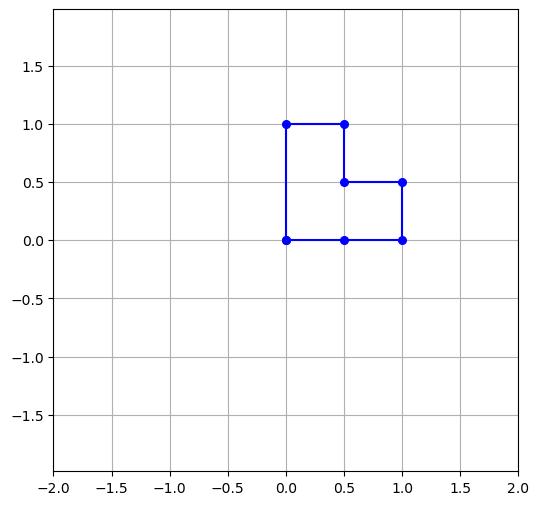

In [23]:
fig(6,6)
shcont(ref);
plt.axis('equal'); plt.axis(2*vec(-1,1,-1,1)); plt.grid()

Pasamos la referencia a 3D, poniéndola "en el suelo", con $z=0$, para poder proyectarla con la matriz de cámara.

In [24]:
# añadimos una coordenada cero a todas las filas
# para convertir un polígono del plano en un polígono
# en el espacio, a altura z=0
def addzerocol(x):
    return np.hstack([x,np.zeros([len(x),1])])

ref3d = addzerocol(ref)

In [25]:
ref3d

array([[0. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0.5, 1. , 0. ],
       [0.5, 0.5, 0. ],
       [1. , 0.5, 0. ],
       [1. , 0. , 0. ],
       [0.5, 0. , 0. ]])

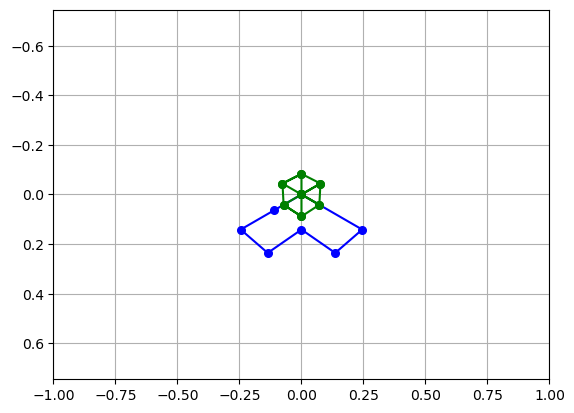

In [26]:
img = htrans(M,ref3d)
shcont(img); 
shcont(htrans(M,cube/3),'g');
plt.axis('equal'); plt.axis(vec(-1,1,1,-1)); plt.grid()
# OJO: invertimos el eje Y

El resultado es consistente con la cámara que hemos creado, que mira desde la posición (2,2,2) hacia el origen, con el eje $Z$ hacia arriba.

Estamos viendo el plano de imagen "físico". Una cámara real produce coordenadas de píxel, que se consiguen multiplicando por la matriz de calibración $\mathsf K$.

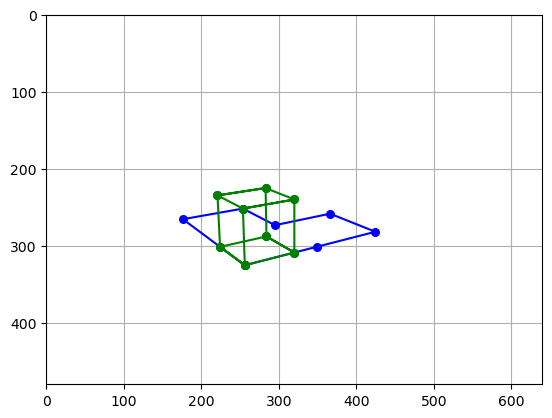

In [27]:
K = Kfov((640,480), 60)
P =  lookat( (-1,-2,1), (1,1,0) )
M = K @ P

img = htrans(M,ref3d)

shcont(img); 
shcont(htrans(M,cube/3),'g');
plt.axis([0,640,480,0]); plt.grid()

Añadimos un slider para mover la posición de esta cámara sintética.

In [28]:
def fun(a = 45):
    cx = 2*np.cos(a*degree)
    cy = 2*np.sin(a*degree)

    K = Kfov((640,480), 65)
    P =  lookat( (cx,cy,1), (0,0,0))
    M = K @ P
    
    sharr(M)
    img = htrans(M,ref3d)
    shcont(img); 
    shcont(htrans(M,cube/3),'g');
    plt.axis([0,640,480,0]); plt.grid();

interactive(fun, a=(-180,180,10))

interactive(children=(IntSlider(value=45, description='a', max=180, min=-180, step=10), Output()), _dom_classe…

Este tipo de cámaras sintéticas se utilizan en los motores gráficos y de videojuegos.

La siguiente función interactiva permite combinar el efecto de zoom y proximidad, manteniendo el tamaño del objeto (*[dolly zoom](https://en.wikipedia.org/wiki/Dolly_zoom)*). Al acercarnos se acentúa el efecto de perspectiva y puntos de fuga. 

In [29]:
def fun(a = 50, r = 2):
    cx = np.cos(a*degree)
    cy = np.sin(a*degree)
    K = np.array([[r*320, 0,    320],
                  [0,    r*320, 240],
                  [0,    0,      1 ]])
    M = K @ lookat(r*vec(cx,cy,0.5),vec(0,0,0))
    img = htrans(M,ref3d)
    shcont(img,color='blue')
    shcont(htrans(M,cube/3),'green');
    plt.axis((0,640,480,0)); plt.grid();

interactive(fun, a=(0,90,5), r = (1,10,0.5))

interactive(children=(IntSlider(value=50, description='a', max=90, step=5), FloatSlider(value=2.0, description…

## Análisis de la matriz de cámara

Es posible extraer los componentes $\mathsf K$, $R$ y $C$ de cualquier matriz de cámara $M$, lo que permite recuperar su posición en el espacio.


Para ello necesitamos un poco de álgebra lineal:

In [30]:
# espacio nulo de una matriz, que sirve para obtener el centro
# de la cámara
def null1(M):
    u,s,vt = la.svd(M)
    return vt[-1,:]


# Descomposición RQ (que no suele estar en los paquetes numéricos)
# pero es fácil expresar en términos de la QR.
# Descompone una matriz como producto de triangular x rotación
# (que es justo la estructura de una matriz de cámara)
# M = K [R |t ]
# el trozo KR te lo da la descomposición rq 
def rq(M):
    Q,R = la.qr(np.flipud(np.fliplr(M)).T)
    R   = np.fliplr(np.flipud(R.T))
    Q   = np.fliplr(np.flipud(Q.T))
    return R,Q


# Descomposición de la matriz de cámara como K,R,C
def sepcam(M):

    K,R = rq (M[:,:3])

    # para corregir los signos de f dentro de K
    s = np.diag(np.sign(np.diag(K)))

    K = K @ s     # pongo signos positivos en K
    K = K/K[2,2]  # y hago que el elemento 3,3 sea 1

    R = s @ R     # cambio los signos igual a R para compensar
    R = R*np.sign(la.det(R)) # y hago que tenga det = 1 (bien orientado)

    # el centro de proyección es el espacio nulo de la matriz,
    # el único punto que la cámara "no puede ver", porque al proyectarlo
    # produce (0,0,0), que es un vector homogéneo "ilegal"
    C = inhomog(null1(M))

    return K,R,C

Vamos a comprobar que `sepcam` ("separa cámara") recupera correctamente los ingredientes con los que sintetizamos una cámara.

In [31]:
K = Kfov((640,480), 60)
P =  lookat(vec(-1,-2,1),vec(1,1,0))
M = K @ P

In [32]:
K,R,C = sepcam(M)

sharr(K)
sharr(R)
sharr(C)

[[554.256   0.    320.   ]
 [  0.    554.256 240.   ]
 [  0.      0.      1.   ]]
[[ 0.832 -0.555  0.   ]
 [-0.148 -0.222 -0.964]
 [ 0.535  0.802 -0.267]]
[-1. -2.  1.]


In [33]:
#           [R | -RC] 
sharr(K @ jc(R , -R @ col(C)))
sharr(M)

[[ 632.216  -50.875  -85.524  615.989]
 [  46.117   69.175 -598.237  782.705]
 [   0.535    0.802   -0.267    2.405]]
[[ 632.216  -50.875  -85.524  615.989]
 [  46.117   69.175 -598.237  782.705]
 [   0.535    0.802   -0.267    2.405]]


Al extraer $R$ y $C$ de la matriz de cámara podemos representar en 3D su centro, el plano de imagen, etc. mediante un sencillo diagrama de alambres.

In [34]:
# esquema en 3d de una cámara
def cameraOutline(M):

    K,R,C = sepcam(M)
    
    # formamos una transformación 3D para mover la cámara en el origen a la posición de M
    rt = jr(jc(R, -R @ col(C)),
            row(0,0,0,1))
    
    sc = 0.3;
    x = 1;
    y = x;
    z = 0.99;
    
    ps =[x,    0,    z,
         (-x), 0,    z,
         0,    0,    z,
         0,    1.3*y,z,
         0,    (-y), z,
         x,    (-y), z,
         x,    y,    z,
         (-x), y,    z,
         (-x), (-y), z,
         x,    (-y), z,
         x,    y,    z,
         0,    y,    z,
         0,    0,    z,
         0,    0,    0,
         1,    1,    z,
         0,    0,    0,
         (-1), 1,    z,
         0,    0,    0,
         (-1), (-1), z,
         0,    0,    0,
         (1), (-1),  z,
         0,    0,    0,
         0,    0,    (2*x)]
    
    ps = np.array(ps).reshape(-1,3)
    return htrans(la.inv(rt), sc * ps)

In [35]:
K = Kfov((640,480), 65)
P =  lookat(vec(2,2,1),vec(0,0,0))
M = K @ P

camline = cameraOutline(M)

def fun(a=-30):
    fig = plt.figure(figsize=(12,8)) # empezamos figura 3D
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('auto')
    plot3(ax,cube/3,'g');
    plot3(ax,ref3d,'r');
    plot3(ax,camline,'b');
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=30., azim=a)

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=-30, description='a', max=180, min=-180, step=10), Output()), _dom_class…

El eje Y de la cámara (que crece hacia abajo) sobresale un poco para que sepamos cuál es.

Este esquema sirve para comprobar que las operaciones anteriores son coherentes pero las proporciones del dibujo 3D en matplotlib salen incorrectas. Se puede arreglar pero es preferible usar otro tipo de herramientas gráficas (p.ej. OpenGL).  En el siguiente pantallazo sacado de un ejercicio que haremos más adelante con la webcam se ven mejor los ejes (X=azul, Y=amarillo, Z=verde) del sistema de referencia del mundo (establecido por el marcador) y el de la cámara.

<img src="../images/demos/axes.png" width="50%"/>

## Estimación de la matriz de cámara a partir de correspondencias

En el apartado anterior hemos creado una matriz de cámara sintética y hemos comprobado que proyecta los puntos como esperamos. Es la base de los gráficos por ordenador.

En visión artificial nos interesa el problema inverso: dada una imagen en la que hemos detectado un objeto conocido, queremos encontrar de forma automática una matriz $\mathsf M$ que sea un buen modelo de la cámara que tomó la imagen. Con ella podemos añadir efectos de realidad aumentada a la escena, y también deducir la posición desde la que se tomó la imagen. Esto es útil para la navegación visual de robots y otras aplicaciones de localización.

El problema de obtener la matriz de cámara a partir de correspondencias 3D $\rightarrow$ 2D se conoce como *[camera resection](https://en.wikipedia.org/wiki/Camera_resectioning)*.
Igual que ocurre con las homografías planas, la matriz de cámara completa se puede estimar fácilmente resolviendo un sistema de ecuaciones.

Pero para mayor precisión es muy conveniente precalibrar la cámara y estimar solo la "pose" ($R$ y $C$).
Para ello se utiliza la función `solvePnP` de OpenCV ("*Perspective from $n$ Points*) que resuelve la [estimación de pose](https://en.wikipedia.org/wiki/Perspective-n-Point) de forma muy eficiente. Se necesitan solo 3 puntos correspondientes para determinar los 6 parámetros pero para que haya solución única son necesarios 4 ó más.

Veamos cómo se utiliza esta función en un ejemplo sintético.

Usamos el mismo objeto de referencia 3D.

In [36]:
ref3d

array([[0. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0.5, 1. , 0. ],
       [0.5, 0.5, 0. ],
       [1. , 0.5, 0. ],
       [1. , 0. , 0. ],
       [0.5, 0. , 0. ]])

Preparamos una cámara sintética:

In [37]:
K = Kfov((640,480), 67)                        # calibración
P = lookat(vec(-1,-2,1),vec(1,1,0))            # pose
M = K @ P                                      # matriz de cámara

Generamos la imagen:

In [38]:
view = htrans(M,ref3d)
view

array([[264.25359016, 314.49427363],
       [194.57057786, 262.34828209],
       [262.10949747, 250.31459173],
       [298.18618745, 269.14993316],
       [360.13741509, 256.0907631 ],
       [411.22139792, 276.56991615],
       [345.08588443, 293.63587702]])

Para recuperar la pose necesitamos la matriz de calibración $\mathsf K$.

In [39]:
ok,rvec,tvec = cv.solvePnP(ref3d, view, K, (0,0,0,0))
# necesita K y los parámetros de distorsión radial (suponemos que no tiene)

print(ok)  # ha tenido éxito o no en la optimización.
print(rvec) # es una representación compacta de la rotación.
print(tvec) # == -RC

True
[[ 1.7813134 ]
 [-0.5393383 ]
 [ 0.41011227]]
[[-0.2773501 ]
 [ 0.37062466]
 [ 2.40535118]]


El resultado viene "codificado", pero es fácil convertirlo a la forma de matriz que hemos usado anteriormente.

In [40]:
R,_ = cv.Rodrigues(rvec)

sharr(R)                      # orientación
sharr(-R.T @ tvec)            # centro de proyección
sharr(K @ jc(R,tvec))         # matriz de cámara estimada por solvePnP
sharr(M)                      # matriz real

[[ 0.832 -0.555 -0.   ]
 [-0.148 -0.222 -0.964]
 [ 0.535  0.802 -0.267]]
[[-1.]
 [-2.]
 [ 1.]]
[[ 573.316  -11.609  -85.524  635.623]
 [  56.611   84.917 -530.023  756.469]
 [   0.535    0.802   -0.267    2.405]]
[[ 573.316  -11.609  -85.524  635.623]
 [  56.611   84.917 -530.023  756.469]
 [   0.535    0.802   -0.267    2.405]]


Es conveniente empaquetar el procedimiento anterior en una función `pose`, que además de la matriz de cámara estimada devuelve el error cometido por ella con esas correspondencias.

In [41]:
# mide el error de una transformación (p.ej. una cámara)
# rms = root mean squared error
# "reprojection error"
def rmsreproj(view, model, transf):
    err = view - htrans(transf,model)
    return np.sqrt(np.mean(err.flatten()**2))

def pose(K, image, model):
    ok,rvec,tvec = cv.solvePnP(model, image, K, (0,0,0,0))
    if not ok:
        return 1e6, None
    R,_ = cv.Rodrigues(rvec)
    M = K @ jc(R,tvec)
    rms = rmsreproj(image,model,M)
    return rms, M

In [42]:
#    M estimada
rms, Me = pose(K,view,ref3d)

sharr(Me)
print(rms)

[[ 573.316  -11.609  -85.524  635.623]
 [  56.611   84.917 -530.023  756.469]
 [   0.535    0.802   -0.267    2.405]]
1.738444902660347e-08


Se obtiene un error de reproyección que es un cero numérico, ya que los puntos de imagen se han generado con el modelo sin ningún ruido de medida. En la práctica los puntos de interés en las imágenes se detectan con un cierto error.

Vamos a añadir ruido artificial a los puntos de imagen para comprobar cómo se comporta el algoritmo PnP.

In [43]:
def noise(shape):
    import numpy.random as rnd
    return rnd.standard_normal(shape)

Añadimos ruido gausiano de $\sigma =3$ pixels.

In [44]:
noisy_view = view + 3*noise(view.shape)

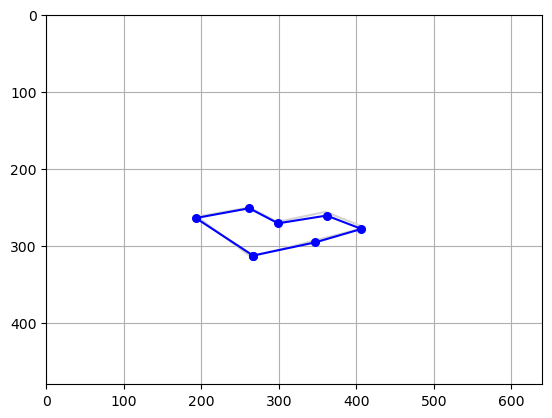

In [45]:
shcont(view, color='lightgray', nodes=False)
shcont(noisy_view)
plt.axis((0,640,480,0)); plt.grid();

In [46]:
rms, Me = pose(K, noisy_view, ref3d)

sharr(Me)
print(rms)

[[ 575.212  -20.715  -69.587  648.064]
 [  72.839   87.519 -527.613  761.078]
 [   0.555    0.794   -0.246    2.429]]
1.5309093001068579


La cámara obtenida es bastante aceptable teniendo en cuenta el nivel de ruido. P. ej., el centro de proyección estimado es

In [47]:
sepcam(Me)[2]

array([-1.0825478 , -2.00290514,  0.96080742])

mientras que el centro real es

In [48]:
sepcam(M)[2]

array([-1., -2.,  1.])

La calidad de la estimación aumenta con el número de correspondencias, siempre que no existan *outliers*, en cuyo caso es imprescindible emplear un método robusto como RANSAC (ya comentado en el tema anterior), que también está disponible en la función `cv.solvePnP`.

## Realidad aumentada

Mediante la técnica anterior es posible estimar la cámara que ha capturado una imagen real siempre que consigamos identificar $n\geq4$ puntos de referencia conocidos. (Con $n=3$ se puede resolver pero hay varias soluciones). Con ella podemos proyectar en la imagen cualquier objeto 3D con la perspectiva correcta.

Lo ideal sería utilizar una referencia 3D grande, con puntos en un amplio rango de distancias. Pero por simplicidad en el ejemplo siguiente trabajaremos con marcadores poligonales.

Usaremos unas cuantas funciones auxiliares para detectar contornos prometedores. Se trata esencialmente del mismo método que usamos en la práctica anterior. Está disponible en umucv pero lo incluimos aquí como recordatorio.

In [49]:
# Utilidades de extracción de contornos (disponibles en umucv)

# area, con signo positivo si el contorno se recorre "counterclockwise"
def orientation(x):
    return cv.contourArea(x.astype(np.float32),oriented=True)

# ratio area/perímetro^2, normalizado para que 100 (el arg es %) = círculo
def redondez(c):
    p = cv.arcLength(c.astype(np.float32),closed=True)
    oa = orientation(c)
    if p>0:
        return oa, 100*4*np.pi*abs(oa)/p**2
    else:
        return 0,0
    
def boundingBox(c):
    (x1, y1), (x2, y2) = c.min(0), c.max(0)
    return (x1, y1), (x2, y2)

# comprobar que el contorno no se sale de la imagen
def internal(c,h,w):
    (x1, y1), (x2, y2) = boundingBox(c)
    return x1>1 and x2 < w-2 and y1 > 1 and y2 < h-2

# reducción de nodos
def redu(c,eps=0.5):
    red = cv.approxPolyDP(c,eps,True)
    return red.reshape(-1,2)

# intenta detectar polígonos de n lados
def polygons(cs,n,prec=2):
    rs = [ redu(c,prec) for c in cs ]
    return [ r for r in rs if r.shape[0] == n ]

# detecta siluetas oscuras que no sean muy pequeñas ni demasiado alargadas
def extractContours(g, minarea=10, minredon=25, reduprec=1):
    #gt = cv.adaptiveThreshold(g,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,101,-10)
    ret, gt = cv.threshold(g,189,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    contours = cv.findContours(gt, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)[-2]

    h,w = g.shape
    
    tharea = (min(h,w)*minarea/100.)**2 
    
    def good(c):
        oa,r = redondez(c)
        black = oa > 0 # and positive orientation
        return black and abs(oa) >= tharea and r > minredon

    ok = [redu(c.reshape(-1,2),reduprec) for c in contours if good(c)]
    return [ c for c in ok if internal(c,h,w) ]

La siguiente imagen de prueba contiene varios marcadores con la forma que hemos estado utilizando. Intentamos detectarlos como polígonos de 6 lados.

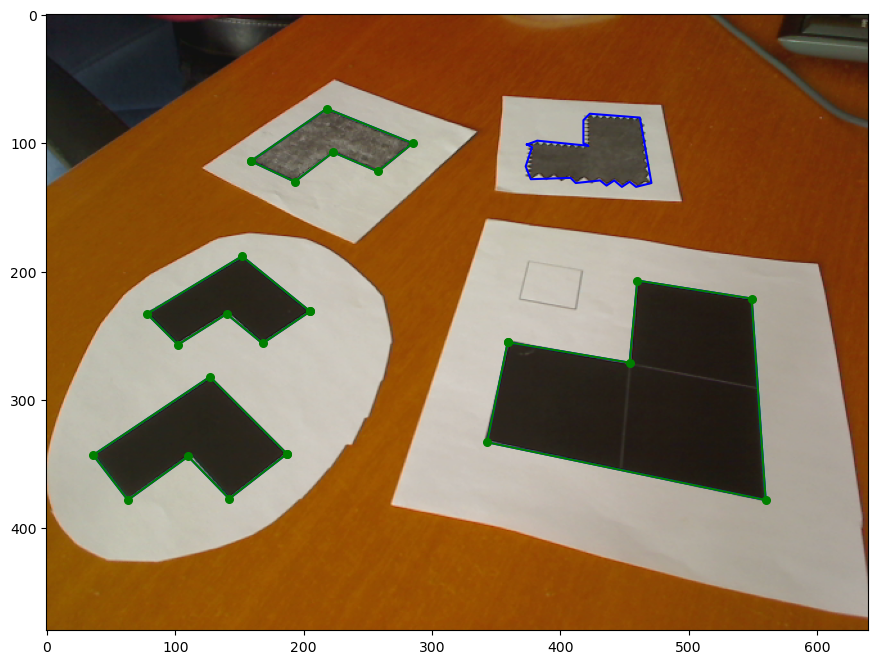

In [50]:
img = readrgb('marker.png')
g = rgb2gray(img)

conts = extractContours(g, reduprec=3)
good = polygons(conts,6)

fig(12,8)
plt.imshow(img); ax = plt.axis();
for c in conts:
    shcont(c,nodes=False,color='blue')
for g in good:
    shcont(g,color='green')
plt.axis(ax);

El que tiene los bordes en ziz-zag no se reduce a 6 lados con el nivel de reducción especificado. Observa lo que ocurre con reduprec=10.

Este método tiene poca precisión en la localización y será muy inestable cuando trabajemos con cámaras en vivo. En cualquier caso, sigamos adelante a ver lo que conseguimos.

Los vértices del marcador que se ve abajo a la izquierda son los siguientes:

In [51]:
good[0]

array([[187, 342],
       [142, 377],
       [110, 344],
       [ 63, 378],
       [ 36, 343],
       [127, 282]], dtype=int32)

El objeto 3D de referencia es el objeto `ref3d` anterior pero quitándole el último punto auxiliar que añadimos para marcar el eje X.

In [52]:
marker = ref3d[:-1]

marker

array([[0. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0.5, 1. , 0. ],
       [0.5, 0.5, 0. ],
       [1. , 0.5, 0. ],
       [1. , 0. , 0. ]])

La matriz de calibración de la cámara es aproximadamente esta:

In [53]:
K = Kfov((640,480), 64)

Calculamos la pose de la cámara:

In [54]:
pose(K, good[0].astype(float), marker)

(25.763664691963218,
 array([[-4.70509457e+02, -3.62356986e+02,  1.09416157e+02,
          9.48579537e+02],
        [-1.55596665e+02, -1.66230471e+02, -5.17697536e+02,
          1.79537571e+03],
        [ 4.23285696e-02, -9.86269613e-01, -1.59626261e-01,
          5.24209514e+00]]))

El primer número del resultado es el error del modelo: 26 pixels. Es enorme. Esto se debe a que el polígono detectado "no empieza" en el mismo vértice que el modelo. Las correspondencias son incorrectas. Esto ya nos ocurrió en la práctica anterior. De nuevo, probamos todos los puntos de partida y nos quedamos con el mejor.

In [55]:
def rots(c):
    return [np.roll(c,k,0) for k in range(len(c))]

rots(good[0])

[array([[187, 342],
        [142, 377],
        [110, 344],
        [ 63, 378],
        [ 36, 343],
        [127, 282]], dtype=int32),
 array([[127, 282],
        [187, 342],
        [142, 377],
        [110, 344],
        [ 63, 378],
        [ 36, 343]], dtype=int32),
 array([[ 36, 343],
        [127, 282],
        [187, 342],
        [142, 377],
        [110, 344],
        [ 63, 378]], dtype=int32),
 array([[ 63, 378],
        [ 36, 343],
        [127, 282],
        [187, 342],
        [142, 377],
        [110, 344]], dtype=int32),
 array([[110, 344],
        [ 63, 378],
        [ 36, 343],
        [127, 282],
        [187, 342],
        [142, 377]], dtype=int32),
 array([[142, 377],
        [110, 344],
        [ 63, 378],
        [ 36, 343],
        [127, 282],
        [187, 342]], dtype=int32)]

Una de las rotaciones consigue un buen ajuste:

In [56]:
[ pose(K, v.astype(float), marker) for v in rots(good[0]) ]

[(25.763664691963218,
  array([[-4.70509457e+02, -3.62356986e+02,  1.09416157e+02,
           9.48579537e+02],
         [-1.55596665e+02, -1.66230471e+02, -5.17697536e+02,
           1.79537571e+03],
         [ 4.23285696e-02, -9.86269613e-01, -1.59626261e-01,
           5.24209514e+00]])),
 (0.6115985587573869,
  array([[-5.06234199e+02,  2.38688942e+02, -2.26733665e+02,
           6.78934450e+02],
         [ 1.61732297e+02,  1.78810045e+02, -5.11588958e+02,
           1.50707145e+03],
         [-4.84892369e-01, -4.17661561e-01, -7.68399773e-01,
           5.34350803e+00]])),
 (19.620493308729333,
  array([[ 2.39882383e+02,  5.51985318e+02,  4.92166766e+01,
           1.39734621e+02],
         [ 4.83196464e+02, -9.56324484e+01,  2.77901497e+02,
           1.45764225e+03],
         [ 8.30860285e-01,  2.62404292e-01, -4.90729227e-01,
           4.23537658e+00]])),
 (291.60758511201857,
  array([[-2.01781061e+02, -3.74872225e+01, -5.67919661e+02,
           1.73575432e+02],
         [-4.

Lo encapsulamos en una función:

In [57]:
# probamos todas las asociaciones de puntos imagen con modelo
# y nos quedamos con la que produzca menos error
def bestPose(K,view,model):
    poses = [ pose(K, v.astype(float), model) for v in rots(view) ]
    return sorted(poses,key=lambda p: p[0])[0]

In [58]:
err,Me = bestPose(K,good[0],marker)
print(err)

0.6115985587573869


Dibujamos la cámara estimada en el espacio junto con el marcador detectado y comprobamos visualmente que la posición relativa es correcta.

In [59]:
camline = cameraOutline(Me)

def fun(a=-30):
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect('auto')
    plot3(ax,marker,'r');
    plot3(ax,camline,'b');
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=30., azim=a)
    

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=-30, description='a', max=180, min=-180, step=10), Output()), _dom_class…

A continuación proyectamos el marcador sobre la imagen.

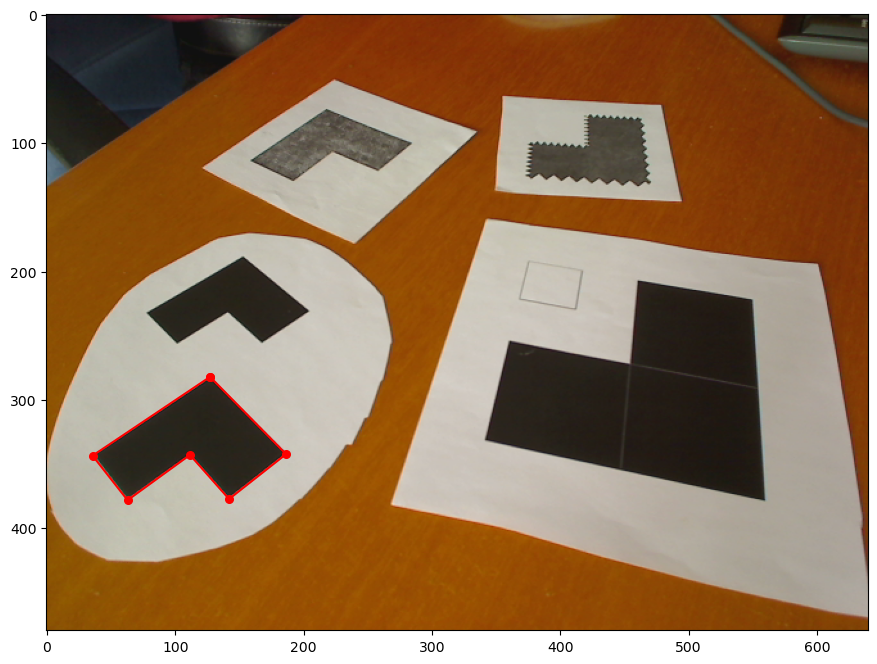

In [60]:
fig(12,8)
plt.imshow(img); ax = plt.axis();

shcont( htrans(Me,marker), color='red')

plt.axis(ax);

Aparece en la posición correcta. No hemos dibujado el polígono detectado, sino la proyección del marcador real con la cámara estimada. El hecho de que quede tan bien ajustado indica que es una aproximación aceptable a la cámara real. Podemos confirmarlo con puntos conocidos que no hemos usado en la estimación, como por ejemplo el cuadro gris que hay dibujado en el marcador más grande.

0.7259416004502588


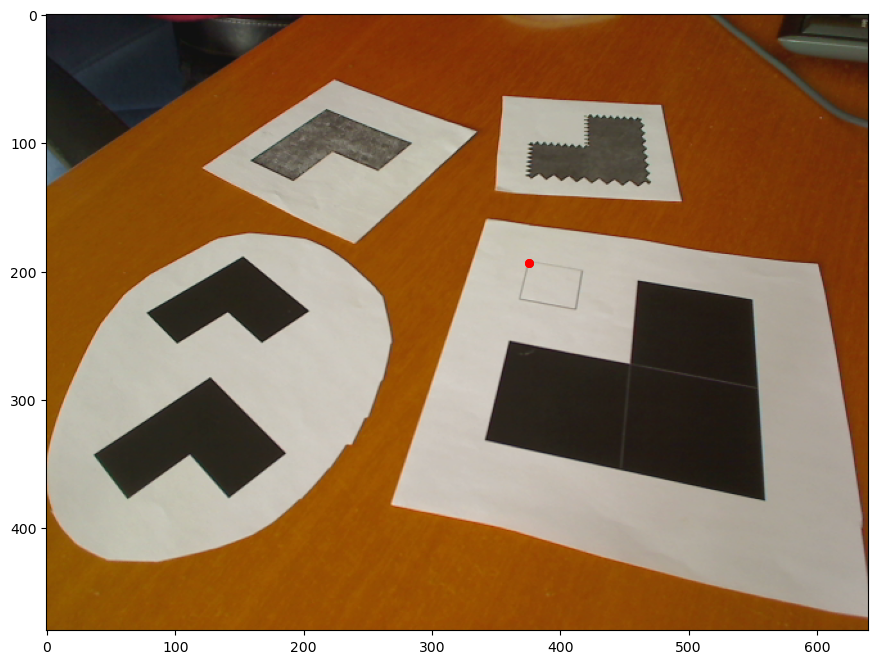

In [61]:
err,Me = bestPose(K,good[2],marker)
print(err)

fig(12,8)
plt.imshow(img); ax = plt.axis();

shcont( htrans(Me, [(1,1,0)] ), color='red')

plt.axis(ax);

Lo importante es que la matriz de cámara estimada, aunque se ha obtenido con información de un solo plano de la escena, sirve para proyectar puntos de todo el espacio y permite añadir objetos artificiales a cualquier altura.

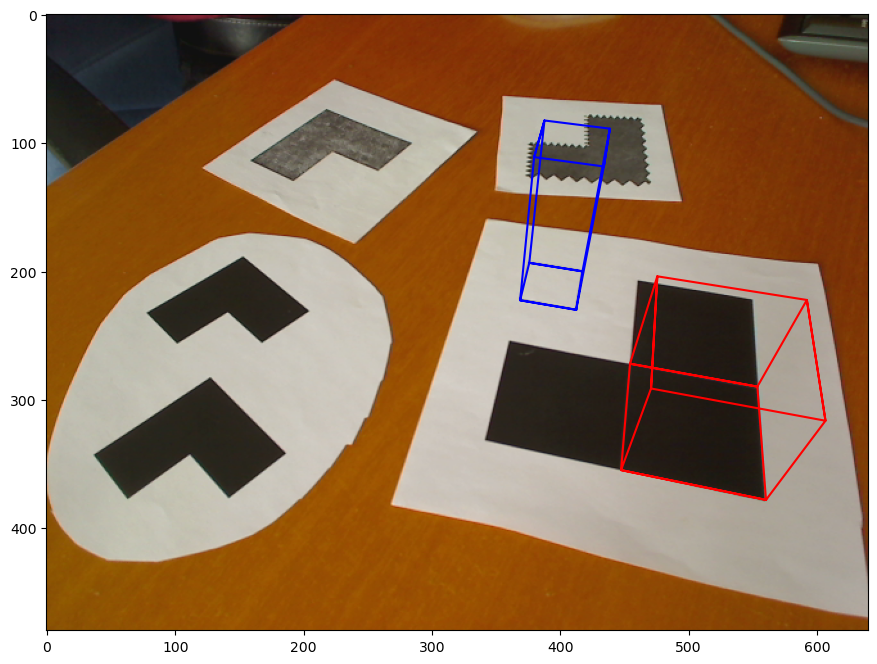

In [62]:
fig(12,8)
plt.imshow(img); ax = plt.axis();
shcont( htrans(Me, cube * (1/4,1/4,0.75) + (0.75,0.75,0)), nodes=False,color='blue')
shcont( htrans(Me, cube/2), nodes=False,color='red')
plt.axis(ax);

Cada referencia detectada da lugar a su propia matriz de cámara estimada. Todas ellas se refieren a la misma cámara física, pero cada matriz está expresada en un sistema de referencia distinto.

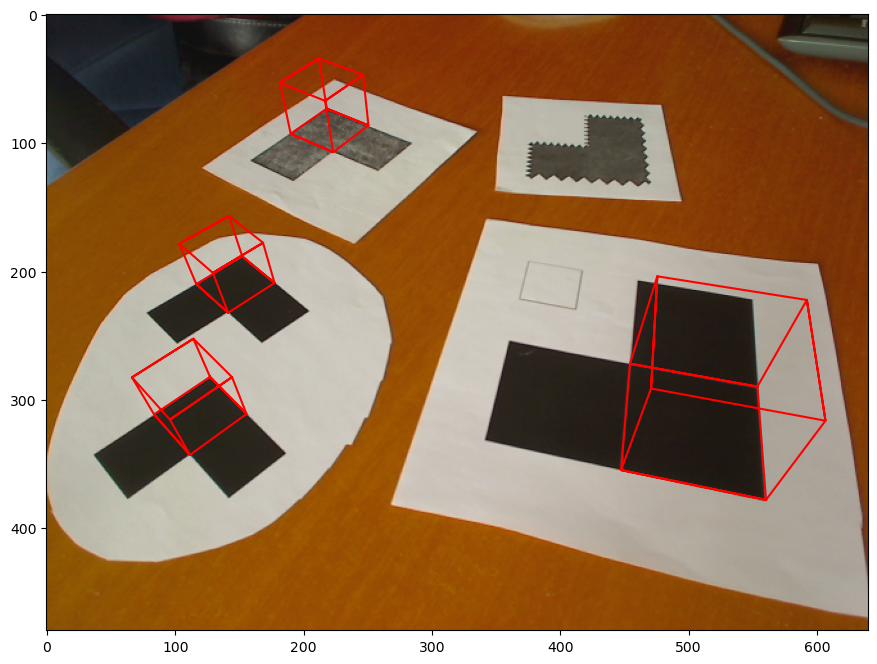

In [63]:
fig(12,8)
plt.imshow(img); ax = plt.axis();
for g in good:
    err,Me = bestPose(K,g,marker)
    if err < 2:
        shcont(htrans(Me,cube/2),nodes=False,color='red')
plt.axis(ax);

Ojo: como en la imagen el eje Y está cambiado, para que la pose se calcule con los ejes correctos el sentido de recorrido del marcador debe ser el contrario al de la imagen.

In [64]:
orientation(marker[:,:2])

-0.75

In [65]:
orientation(good[0])

7256.5

Veamos otro ejemplo. Vamos a intentar detectar las flechas pintadas en el carril bici.

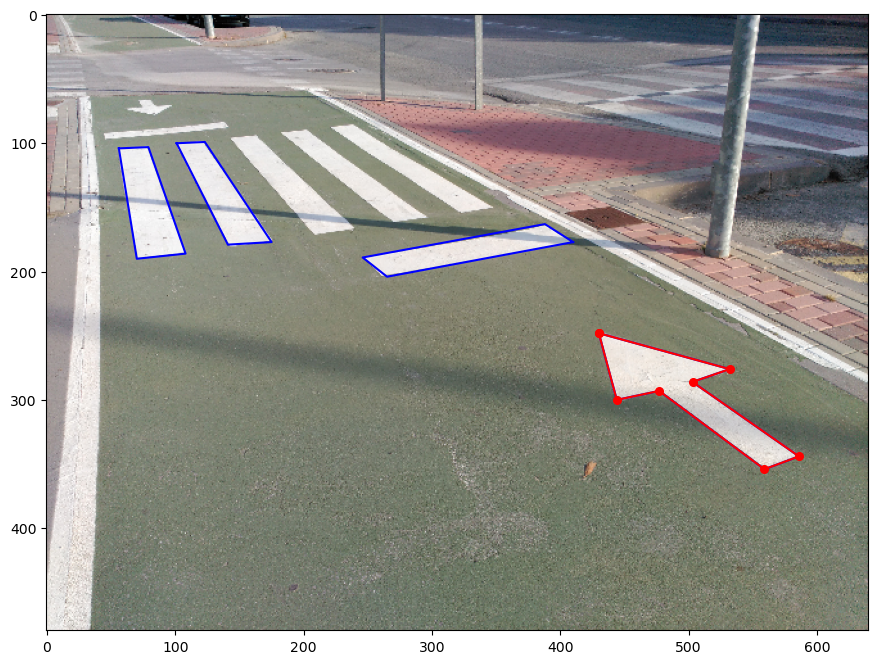

In [66]:
img = cv.resize(readrgb('arrow2.jpg'),(640,480))
g = 255-rgb2gray(img)

conts = extractContours(g, minredon=10, reduprec=5)
good = polygons(conts,7)

fig(12,8)
plt.imshow(img); ax = plt.axis();
for c in conts:
    shcont(c,nodes=False,color='blue')
for g in good:
    shcont(g,color='red')
plt.axis(ax);

Tomamos una imagen frontal para sacar de ella el modelo:

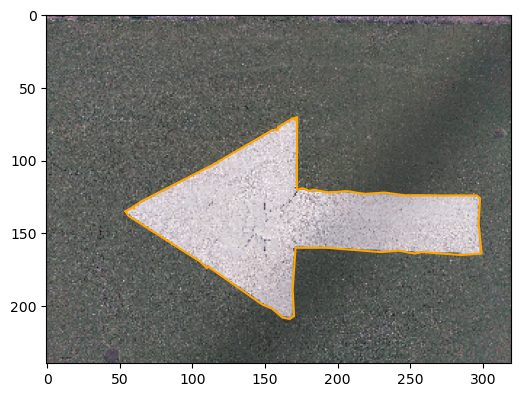

In [67]:
imgm = cv.resize(readrgb('arrow1.jpg'),(320,240))
g = 255-rgb2gray(imgm)

conts = extractContours(g, minredon=10)

fig(6,6)
plt.imshow(imgm); ax = plt.axis();
for c in conts:
    shcont(c,nodes=False,color='orange')
plt.axis(ax);

Por prueba y error cambiamos el nivel de reducción hasta que se detecte el polígono.

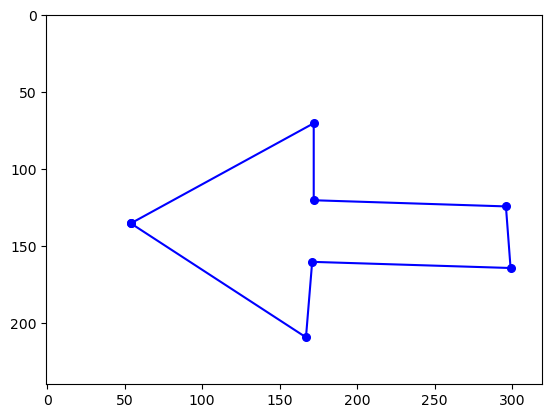

In [68]:
arrow = polygons([redu(c,3) for c in conts],7)[0]

shcont(arrow)

plt.axis(ax);

Ajustamos su tamaño para que mida una unidad de ancho.

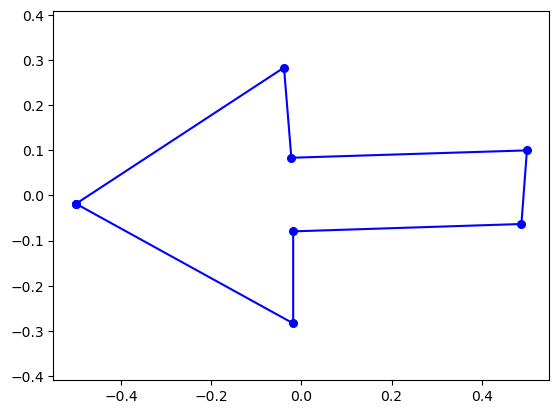

In [69]:
def autoscale(cont):
    (x1, y1), (x2, y2) = cont.min(0), cont.max(0)
    s = max(x2-x1,y2-y1)
    c = vec(x1+x2,y1+y2)/2
    h = np.dot(scale(1/vec(s,s)) , desp(-c))
    return htrans(h,cont)

arrow = autoscale(arrow)

shcont(arrow); plt.axis('equal');

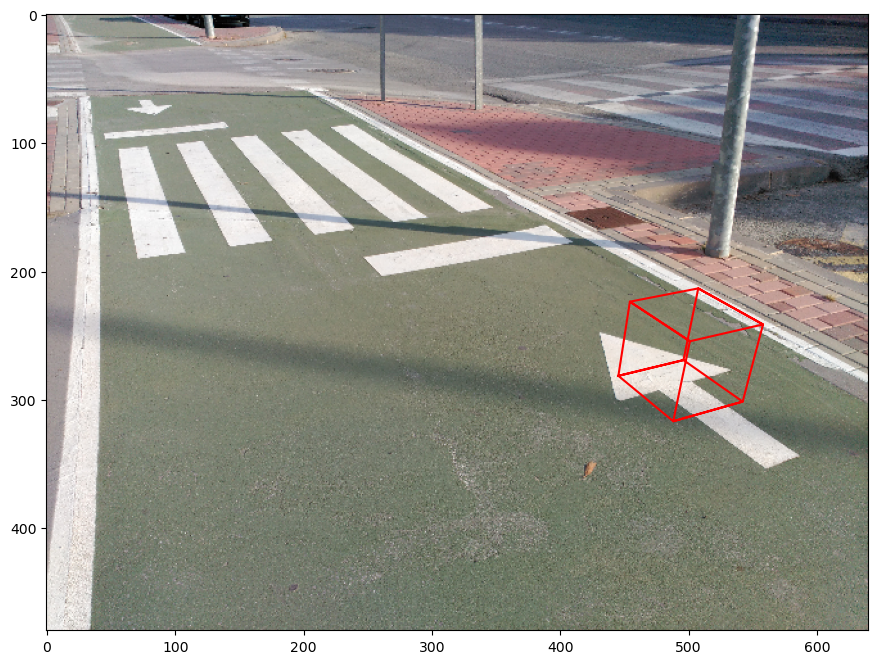

In [70]:
cubito = (cube-row(0.5,0.5,0))/3

fig(12,8)
plt.imshow(img); ax = plt.axis();
for g in [good[0]]:
    err,Me = bestPose(K,g,np.flipud(addzerocol(arrow)))
    if err < 2:
        shcont(htrans(Me,cubito),nodes=False,color='red')
plt.axis(ax);

Ejercicio: añade una flecha virtual en un poste vertical que apunte en la misma dirección que la flecha real.

## Realidad aumentada con la webcam en vivo

Las posibilidades son infinitas.

<video controls src="../images/demos/dynamic.mp4"></video>

En la sesión práctica haremos paso a paso una pequeña aplicación para mostrar en 3D y en tiempo real la posición de la cámara y efectos de realidad aumentada a partir de un marcador artificial. Es la base de el ejercico **RA**.

Utilizando OpenGL se pueden conseguir efectos 3D más realistas. 

<img src="../images/demos/opengl-ra1.png" width="40%"/>

<img src="../images/demos/opengl-ra2.png" width="40%"/>

En la actualidad hay numerosos ["frameworks" de realidad aumentada](https://en.wikipedia.org/wiki/List_of_augmented_reality_software). Algunos admiten escenas naturales, sin necesidad de marcadores.